# Baltimore City Employee Salary Analysis

Analyzing Baltimore City government employee salaries using SQL to compare pre-COVID (2019) and post-COVID (2022) workforce data.

**Data Source:** [Baltimore Open Data](https://data.baltimorecity.gov/)

In [23]:
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd

## Setup: Download Data and Create Database

First, download the salary data from Baltimore Open Data and create a SQLite database.

In [24]:
# Download data from Baltimore Open Data
csv_url = "https://opendata.arcgis.com/api/v3/datasets/afdaf8cca48a4bcea9282a781e9190a6_0/downloads/data?format=csv&spatialRefId=4326"
df_all = pd.read_csv(csv_url)

# Filter for 2019 and 2021 (fiscal years are strings like 'FY2019')
df_2019 = df_all[df_all['fiscalYear'] == 'FY2019'].copy()
df_2021 = df_all[df_all['fiscalYear'] == 'FY2021'].copy()

# Create a 'name' column by combining first and last name
df_2019['name'] = df_2019['firstName'] + ' ' + df_2019['lastName']
df_2021['name'] = df_2021['firstName'] + ' ' + df_2021['lastName']

# Create SQLite database
conn = sqlite3.connect("baltimore_salaries.db")
df_2019.to_sql('salary_2019', conn, index=False, if_exists='replace')
df_2021.to_sql('salary_2021', conn, index=False, if_exists='replace')
cur = conn.cursor()

print(f"Database created with {len(df_2019)} rows for 2019 and {len(df_2021)} rows for 2021")

Database created with 13134 rows for 2019 and 14179 rows for 2021


## Part A: Pulling Data Using SQL

### Comparing the number of employees per year

In [25]:
# How many total employees were there in Fiscal Year 22?
total2021 = 0
cur.execute("SELECT COUNT (*) FROM salary_2021")
total2021 = cur.fetchone()[0]
print(f"Total employees in 2021: {total2021}")

Total employees in 2021: 14179


In [26]:
# How does this compare to pre-COVID (2019)?
total2019 = 0
cur.execute("SELECT COUNT(*) FROM salary_2019")
total2019 = cur.fetchone()[0]
if total2021 > total2019:
    print("2021 had more employees")
else:
    print("2019 had more employees")

2021 had more employees


### Examining job titles and salaries

In [27]:
# Find every city employee in FY2021
people2021 = []
cur.execute("SELECT name FROM salary_2021")
people2021 = cur.fetchall()
print(f"Number of employees: {len(people2021)}")
print(f"First employee: {people2021[0]}")

Number of employees: 14179
First employee: ('Kareem Aaron',)


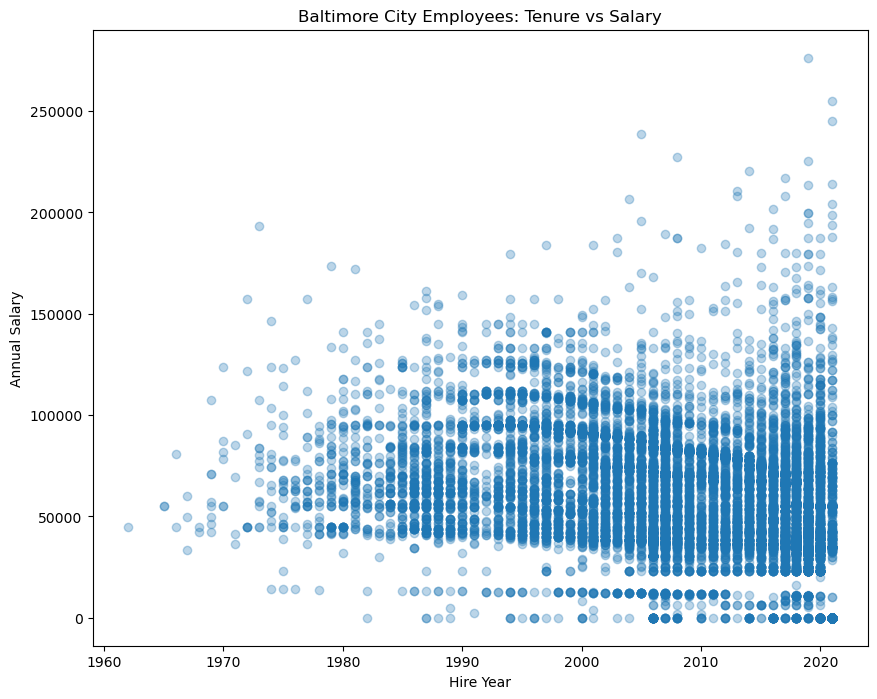

In [28]:
# Hire year vs salary for top earners
cur.execute("SELECT SUBSTR(hireDate, 1, 4), annualSalary FROM salary_2021 WHERE hireDate IS NOT NULL")
jobInfo = cur.fetchall()

# Breaking apart into x/y
x = [int(row[0]) for row in jobInfo if row[0] is not None]
y = [row[1] for row in jobInfo if row[0] is not None]

# Plotting
plt.figure(figsize=(10,8))
plt.scatter(x, y, alpha=0.3)
plt.xlabel('Hire Year')
plt.ylabel('Annual Salary')
plt.title('Baltimore City Employees: Tenure vs Salary')
plt.show()

Employees hired earlier generally earn more, showing the impact of tenure on salary through raises and promotions over time.

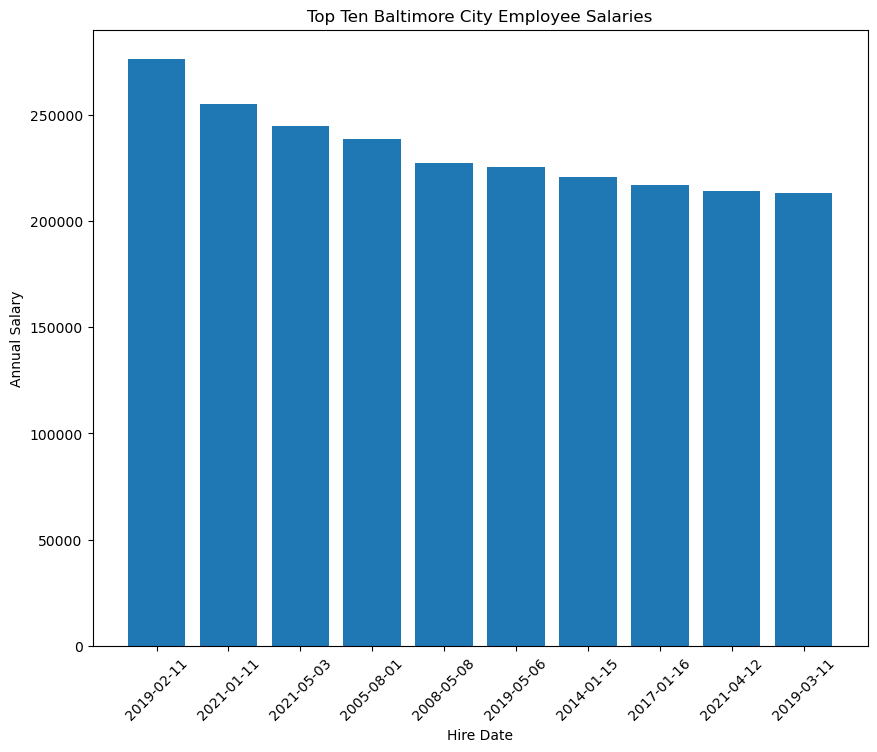

In [29]:
# Bar chart: Who are the top 10 highest paid employees?
cur.execute("SELECT hireDate, annualSalary FROM salary_2021 ORDER BY annualSalary DESC LIMIT 10")
jobInfo = cur.fetchall()

# Breaking apart into x/y
x = [row[0] for row in jobInfo]
y = [row[1] for row in jobInfo]

# Plotting
plt.figure(figsize=(10,8))
plt.bar(x, y)
plt.xlabel('Hire Date')
plt.ylabel('Annual Salary')
plt.title('Top Ten Baltimore City Employee Salaries')
plt.xticks(rotation=45)
plt.show()

The highest paid employees were hired across different years, suggesting these are executive/leadership roles where tenure matters less than position level.

In [30]:
# How many employees make over $250,000?
quarter_mil = 0
cur.execute("SELECT COUNT(*) FROM salary_2021 WHERE annualSalary > 250000")
quarter_mil = cur.fetchone()[0]
print(f"Employees making over $250,000: {quarter_mil}")

Employees making over $250,000: 2


In [31]:
# Top 10 job titles with highest average salary (at least 50 employees)
cur.execute("SELECT jobClass, avg(annualSalary), COUNT(*) FROM salary_2021 GROUP BY jobClass HAVING COUNT(*) >= 50 ORDER BY avg(annualSalary) DESC LIMIT 10")
top10 = cur.fetchall()

print("Top 10 Highest Paying Jobs (min 50 employees):")
print("-" * 60)
for job, salary, count in top10:
    print(f"{job}: ${salary:,.2f} avg ({count} employees)")

Top 10 Highest Paying Jobs (min 50 employees):
------------------------------------------------------------
OPERATIONS MANAGER II: $132,755.13 avg (60 employees)
POLICE LIEUTENANT EID: $120,661.63 avg (51 employees)
POLICE LIEUTENANT: $119,838.55 avg (65 employees)
OPERATIONS MANAGER I: $114,876.57 avg (72 employees)
OPERATIONS OFFICER V: $107,201.03 avg (68 employees)
POLICE SERGEANT EID: $104,193.54 avg (108 employees)
POLICE SERGEANT: $101,816.90 avg (263 employees)
FIRE LT SUPPRESSION: $86,774.47 avg (134 employees)
POLICE OFFICER EID: $84,763.39 avg (272 employees)
FIREFIGHTER SUPPRESSION: $81,043.68 avg (50 employees)


### Understanding the agencies

In [32]:
# How many agencies have employees in 2021?
agency_21 = 0
cur.execute("SELECT COUNT(DISTINCT agencyName) FROM salary_2021")
agency_21 = cur.fetchone()[0]
print(f"Number of agencies: {agency_21}")

Number of agencies: 63


In [33]:
# Five agencies with lowest average annual salaries
cur.execute("SELECT agencyName, avg(annualSalary) FROM salary_2021 GROUP BY agencyName ORDER BY avg(annualSalary) LIMIT 5")
poorly_paid = cur.fetchall()

print("5 Lowest Paying Agencies:")
print("-" * 50)
for agency, salary in poorly_paid:
    print(f"{agency}: ${salary:,.2f} avg")

5 Lowest Paying Agencies:
--------------------------------------------------
D01: $0.00 avg
R01: $0.00 avg
W07 - OED - Youth Works: $2,917.75 avg
Transportation - Crossing Guards: $11,875.81 avg
Elections: $13,399.00 avg


### COVID Impact Analysis (Joining Tables)

In [34]:
# How many people who worked in 2019 still work for the city in 2021?
COVID_jobs = 0
cur.execute("SELECT COUNT(*) FROM salary_2019 JOIN salary_2021 on salary_2019.name = salary_2021.name")
COVID_jobs = cur.fetchone()[0]
print(f"Employees who stayed through COVID: {COVID_jobs}")

Employees who stayed through COVID: 11281


In [35]:
# Average salary raise for employees who stayed
sal_raise = 0
cur.execute("SELECT avg(salary_2021.annualSalary - salary_2019.annualSalary) FROM salary_2019 JOIN salary_2021 on salary_2019.name = salary_2021.name")
sal_raise = cur.fetchone()[0]
print(f"Average raise for retained employees: ${sal_raise:,.2f}")

Average raise for retained employees: $4,173.94


## Conclusions

1. **Workforce Growth:** Baltimore actually gained employees during COVID: from 13,134 in 2019 to 14,179 in 2021 (an increase of 1,045 employees). This was surprising given the pandemic.

2. **Employee Retention:** 11,281 employees stayed with the city from 2019 to 2021, receiving an average raise of $4,173.94.

3. **Salary Insights:** 
   - The highest paid positions are Operations Managers and Police leadership
   - Longer tenure generally correlates with higher salaries
   - Some agencies like "D01" and "R01" show $0 average salary (likely data issues or unpaid positions)

In [21]:
conn.close()